In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

In [2]:
def load_data(data_dir):
    '''
    Carrega os arquivos da pasta, separando as imagens e os labels correspondentes já codificados 
    '''
    # Lista para armazenar imagens e rótulos
    images = []
    labels = []
    
    # Loop sobre os arquivos no diretório
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):  # Imagens tem extensão .png
            img = load_img(os.path.join(data_dir, filename), target_size=(300, 300))
            img_array = img_to_array(img)
            images.append(img_array)
            
            # Extrair rótulo do nome do arquivo
            label = filename.split(' ')[0]  # Pega o rótulo antes do espaço em branco
            labels.append(label)

    # Codificar rótulos em números
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Converter para array numpy
    images = np.array(images)
    labels = to_categorical(labels)

    return images, labels, label_encoder

In [3]:
def compute_class_weights(y_train):
    # Calcular pesos das classes baseados na distribuição dos dados
    class_weights = {}
    total_samples = len(y_train)
    num_classes = len(np.unique(np.argmax(y_train, axis=1)))
    for i in range(num_classes):
        class_count = np.sum(np.argmax(y_train, axis=1) == i)
        class_weights[i] = total_samples / (num_classes * class_count)

    return class_weights

In [4]:
def get_model(input_shape=(300,300,3), num_class=3):
    # Carregar o modelo VGG-16 pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar as camadas do modelo base
    for layer in base_model.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = Lambda(preprocess_input)(inputs)  # Aplicando a função preprocess_input como uma camada Lambda
    x = base_model(x, training=False)  # Modo de inferência para base_model
    # Adicionar camadas personalizadas
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs, predictions)
    
    # Compilar o modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Apresenta um sumário do modelo
    #model.summary()

    return model

In [5]:
def classification_metrics_multiclass(y_true, y_pred, model, fold):
    '''
    Generate multiclass classification analysis
    '''
    
    # Confusion matrix for multiclass
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_score_per_class = f1_score(y_true, y_pred, average=None)
    
    # Overall metrics
    accuracy = (cm.diagonal().sum()) / cm.sum()
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    try:
        auc_value = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except ValueError:
        auc_value = None  # AUC calculation might fail if there's not enough variety in predictions
    
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        "model": model, 
        "fold": fold,
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(), 
        "recall_per_class": recall_per_class.tolist(), 
        "f1_score_per_class": f1_score_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_score_macro": f1_score_macro,
        "auc": auc_value, 
        "kappa": kappa
    }

In [6]:
def plot_cm(y_true, y_pred_classes, label_encoder):
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
# Diretório com suas imagens
data_dir = 'C:/Users/estela.ribeiro/JupyterNotebooks/side_job_breat_cancer/dataset/images/'

# Carregar os dados
images, labels, label_encoder = load_data(data_dir)

# Parametros
input_shape = (300, 300, 3)
num_classes = 3  # Número de classes: benign, malign, normal

In [8]:
# Definir a validação cruzada k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

---------
Starting Fold: 1 ...


Epoch 1/5


20/20 [==============================] - 615s 31s/step - loss: 11.9819 - accuracy: 0.5577 - val_loss: 2.8269 - val_accuracy: 0.6731
Epoch 2/5
20/20 [==============================] - 608s 31s/step - loss: 1.1468 - accuracy: 0.7933 - val_loss: 1.0275 - val_accuracy: 0.7949
Epoch 3/5
20/20 [==============================] - 590s 30s/step - loss: 0.3544 - accuracy: 0.8702 - val_loss: 0.8784 - val_accuracy: 0.7564
Epoch 4/5
20/20 [==============================] - 585s 30s/step - loss: 0.2416 - accuracy: 0.9295 - val_loss: 0.8973 - val_accuracy: 0.7885
Epoch 5/5
5/5 [==============================] - 128s 26s/step


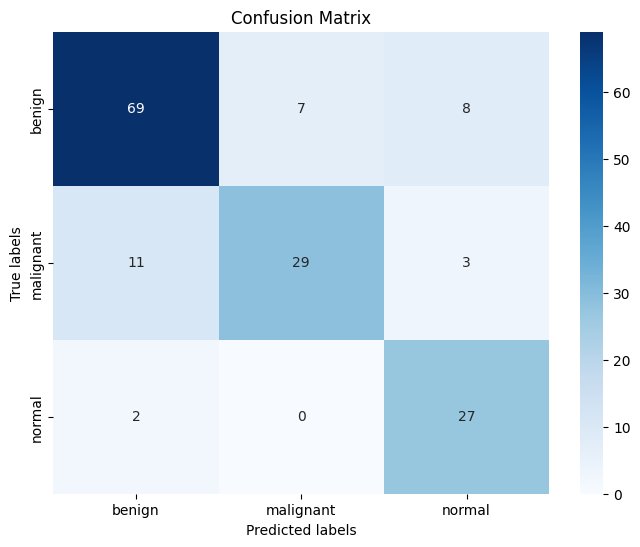

{'model': 'vgg16', 'fold': 1, 'confusion_matrix': array([[69,  7,  8],
       [11, 29,  3],
       [ 2,  0, 27]], dtype=int64), 'accuracy': 0.8012820512820513, 'precision_per_class': [0.8414634146341463, 0.8055555555555556, 0.7105263157894737], 'recall_per_class': [0.8214285714285714, 0.6744186046511628, 0.9310344827586207], 'f1_score_per_class': [0.8313253012048193, 0.7341772151898734, 0.8059701492537313], 'precision_macro': 0.7858484286597252, 'recall_macro': 0.8089605529461182, 'f1_score_macro': 0.7904908885494747, 'auc': None, 'kappa': 0.673199080956886}
---------
Starting Fold: 2 ...
Epoch 1/5
20/20 [==============================] - 634s 32s/step - loss: 11.0380 - accuracy: 0.5433 - val_loss: 2.3161 - val_accuracy: 0.7885
Epoch 2/5
20/20 [==============================] - 591s 30s/step - loss: 1.1875 - accuracy: 0.8205 - val_loss: 0.9091 - val_accuracy: 0.7821
Epoch 3/5
20/20 [==============================] - 596s 30s/step - loss: 0.3689 - accuracy: 0.9038 - val_loss: 0.7766 - v

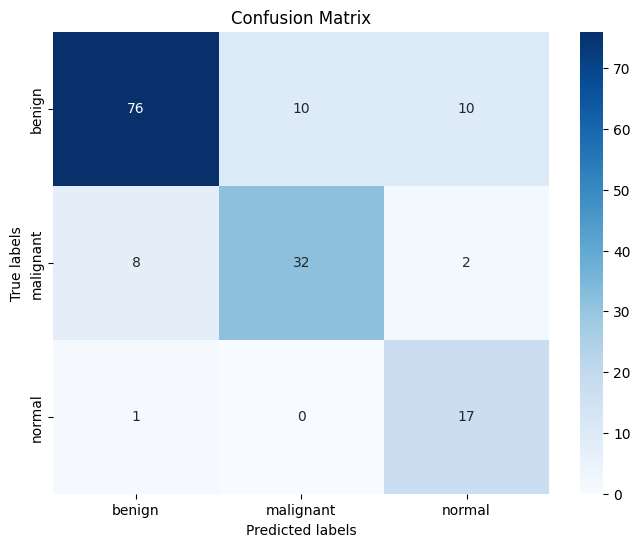

{'model': 'vgg16', 'fold': 2, 'confusion_matrix': array([[76, 10, 10],
       [ 8, 32,  2],
       [ 1,  0, 17]], dtype=int64), 'accuracy': 0.8012820512820513, 'precision_per_class': [0.8941176470588236, 0.7619047619047619, 0.5862068965517241], 'recall_per_class': [0.7916666666666666, 0.7619047619047619, 0.9444444444444444], 'f1_score_per_class': [0.8397790055248618, 0.7619047619047619, 0.723404255319149], 'precision_macro': 0.7474097685051032, 'recall_macro': 0.8326719576719576, 'f1_score_macro': 0.7750293409162575, 'auc': None, 'kappa': 0.6518358531317494}
---------
Starting Fold: 3 ...
Epoch 1/5
20/20 [==============================] - 595s 30s/step - loss: 15.8333 - accuracy: 0.5369 - val_loss: 2.7436 - val_accuracy: 0.7308
Epoch 2/5
15/20 [=====================>........] - ETA: 2:01 - loss: 2.3208 - accuracy: 0.7812Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\estela.ribeiro\AppData\Local\anaconda3\envs\estudos\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\estela.ribeiro\AppData\Local\Temp\ipykernel_7276\2624971896.py", line 17, in <module>
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), class_weight=class_weights)
  File "C:\Users\estela.ribeiro\AppData\Local\anaconda3\envs\estudos\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\estela.ribeiro\AppData\Local\anaconda3\envs\estudos\Lib\site-packages\tensorflow\python\eager\context.py", line 1415, in get_graph_debug_info
    pywrap_tfe.TFE_ContextGetGraphDebugInfo(self._handle, name, buffer_)
MemoryError: bad allocation

During handling of the above exception, another exception occurred:

Traceback (most recent call las

In [9]:
# Loop para validação cruzada k-fold
i = 1
for train_index, val_index in kf.split(images):
    
    print(f'---------\nStarting Fold: {i} ...')
    
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Calcular pesos das classes
    class_weights = compute_class_weights(y_train)

    # Criar o modelo
    model = get_model(input_shape, num_classes)

    # Treinar o modelo com pesos de classe
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), class_weight=class_weights)

    # Fazer previsões no conjunto de validação
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Gerar os resultados
    plot_cm(y_true, y_pred_classes, label_encoder)
    results = classification_metrics_multiclass(y_true, y_pred_classes, 'vgg16', i)
    print(results)
    i += 1
    
    # Garantir que zerou o modelo para o proximo loop do k-fold
    del model